# Data

[dataset link](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from itertools import combinations

import sys

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

sys.path.append('../cmeans_math')
import clustering_by_move_evolve as cl_by_me
import cheat_clustering as cheat_clustering

import accuracies
import entry_cluster_assignment

In [7]:
hd_data = pd.read_csv('./data/heart_disease_uci.csv').drop(columns=['id'])
hd_data["class"] = hd_data["num"]
hd_data = hd_data.drop(columns=['num', 'dataset'])
hd_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,class
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
set(hd_data["class"])

{0, 1, 2, 3, 4}

# Prepare data

In [4]:
hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null    object 
 13  class     920 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 100.8+ KB


In [5]:
full_data = hd_data.dropna().copy(deep=True)
len(full_data)

299

In [6]:
full_data["sex"] = pd.Categorical(full_data["sex"]).codes
full_data["cp"] = pd.Categorical(full_data["cp"]).codes
full_data["fbs"] = pd.Categorical(full_data["fbs"]).codes
full_data["restecg"] = pd.Categorical(full_data["restecg"]).codes
full_data["exang"] = pd.Categorical(full_data["exang"]).codes
full_data["slope"] = pd.Categorical(full_data["slope"]).codes
full_data["thal"] = pd.Categorical(full_data["thal"]).codes

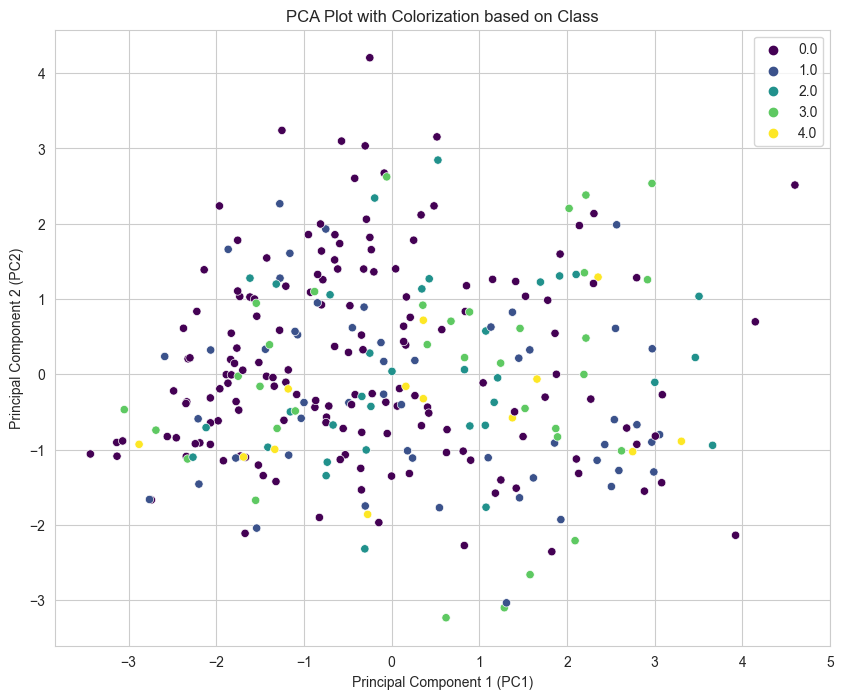

In [7]:
features = full_data.drop('class', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['class'] = full_data['class']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='viridis')
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

# Prepare all data with filling 'none'

In [8]:
for column in ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]:
    hd_data[column].fillna(hd_data[column].mode()[0], inplace=True)

for column in ["trestbps", "chol", "thalch", "oldpeak", "ca"]:
    hd_data[column].fillna(hd_data[column].median(), inplace=True)

In [9]:
hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  920 non-null    float64
 4   chol      920 non-null    float64
 5   fbs       920 non-null    bool   
 6   restecg   920 non-null    object 
 7   thalch    920 non-null    float64
 8   exang     920 non-null    bool   
 9   oldpeak   920 non-null    float64
 10  slope     920 non-null    object 
 11  ca        920 non-null    float64
 12  thal      920 non-null    object 
 13  class     920 non-null    int64  
dtypes: bool(2), float64(5), int64(2), object(5)
memory usage: 88.2+ KB


In [10]:
hd_data["sex"] = pd.Categorical(hd_data["sex"]).codes
hd_data["cp"] = pd.Categorical(hd_data["cp"]).codes
hd_data["fbs"] = pd.Categorical(hd_data["fbs"]).codes
hd_data["restecg"] = pd.Categorical(hd_data["restecg"]).codes
hd_data["exang"] = pd.Categorical(hd_data["exang"]).codes
hd_data["slope"] = pd.Categorical(hd_data["slope"]).codes
hd_data["thal"] = pd.Categorical(hd_data["thal"]).codes

C:\Users\voldo\AppData\Local\Temp\ipykernel_7888\2077837948.py:13: UserWarning: The palette list has more values (15) than needed (5), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,


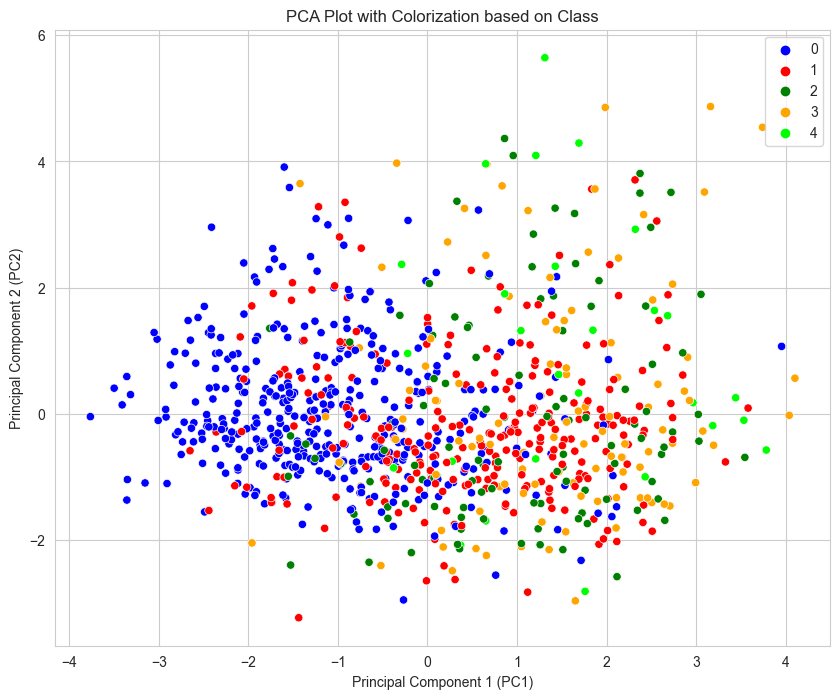

In [11]:
features = hd_data.drop('class', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['class'] = hd_data['class']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'])
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

In [12]:
hd_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,class
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,67,1,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,2
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1
3,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0
4,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0


In [13]:
x_hd = hd_data.drop('class', axis=1)
scaler = StandardScaler()
x_hd = scaler.fit_transform(x_hd)
y_hd = hd_data['class']

x_train_hd, x_test_hd, y_train_hd, y_test_hd = train_test_split(x_hd, y_hd, test_size=0.2, random_state=42)

x_full = full_data.drop('class', axis=1)
scaler = StandardScaler()
x_full = scaler.fit_transform(x_full)
y_full = full_data['class']

x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_full, y_full, test_size=0.3, random_state=42)

In [14]:
print("Filled data train / test split:", len(x_train_hd), "/", len(x_test_hd))
print("No nan data train / test split:", len(x_train_full), "/", len(x_test_full))

Filled data train / test split: 736 / 184
No nan data train / test split: 209 / 90


# Clusterize data hd_data with filling none-values

# I Manhattan distance

In [15]:
obj_results0 = \
    cl_by_me.clustering_by_simple_mahalanobis_density(mat_entries=x_train_hd.tolist(),
                                                      var_min_count_clusters=1,
                                                      var_init_count_clusters=30,
                                                      # evolve_distance="Mahalanobis")
                                                      evolve_distance="Manhattan",
                                                      clustering_type=-1)

obj_results = cheat_clustering.cheat_with_noises_clustering(mat_entries=x_train_hd.tolist(),
                                                            vec_check=y_train_hd.tolist(),
                                                            var_count_clusters=5,
                                                            # var_noise=0.18, # for PCA
                                                            var_noise=0.4,
                                                            # distance="Mahalanobis")
                                                            distance="Manhattan")



count clusters 30
total loss 6.752795863306168
cluster losses: [3.9620685658031247, 5.755824528188204, 10.757129579391545, 6.451875085413969, 6.831952199985922, 3.89781664395359, 6.531733639456762, 9.22412566956423, 6.829993979110557, 6.601542664696221, 5.745892165521869, 9.919398596330556, 4.248671178335152, 6.1830333425837045, 4.15856825598424, 6.678343271902957, 6.836346361480411, 8.0620448385238, 5.390850478949305, 7.894866322183101, 8.391399945149841, 10.578219112343067, 8.10014551730623, 6.939181185301828, 7.128500560739018, 3.5652501029547334, 9.954533024367281, 6.764533562348496, 4.58425026728957, 4.615785254025741]
count elems: [5, 27, 10, 2, 5, 46, 118, 70, 15, 5, 3, 127, 4, 59, 2, 9, 55, 47, 5, 4, 8, 10, 12, 59, 3, 2, 7, 13, 2, 2]
deleted cluster: 2


count clusters 29
total loss 6.619423031841775
cluster losses: [3.960724237182754, 5.754863486535661, 6.451875065191805, 6.81760562141625, 4.126525865365594, 6.129167038447409, 9.871281570448332, 6.8259101066211425, 6.5950049

In [16]:
obj_results.vec_cluster_count = obj_results0.vec_cluster_count
obj_results.vec_total_losses = obj_results0.vec_total_losses

var_accuracy = accuracies.accuracy(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
mat_confusion = accuracies.confusion_matrix(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
accuracies.print_cluster_num(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())




___________________________
recognized: 
cluster: 0
[1, 2, 3, 4, 6, 10, 12, 13, 16, 21, 22, 24, 26, 28, 31, 33, 35, 37, 38, 42, 45, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 64, 67, 69, 72, 75, 76, 78, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 98, 101, 102, 103, 105, 106, 108, 110, 111, 112, 113, 115, 116, 117, 118, 120, 122, 123, 124, 125, 128, 129, 133, 134, 135, 138, 139, 141, 145, 146, 149, 151, 152, 161, 163, 168, 173, 175, 176, 181, 185, 188, 190, 193, 194, 196, 197, 200, 203, 204, 206, 207, 211, 212, 213, 215, 216, 217, 218, 222, 223, 224, 226, 229, 230, 231, 232, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 257, 260, 263, 264, 265, 266, 267, 268, 272, 274, 277, 278, 280, 281, 283, 285, 290, 292, 293, 295, 296, 298, 299, 301, 304, 306, 311, 313, 314, 316, 321, 322, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 343, 344, 345, 346, 350, 351, 352, 353, 354, 355, 366, 370, 371, 374, 375, 377, 378, 381, 388, 391, 393, 394, 

In [17]:
for i in range(len(obj_results.vec_cluster_count)):
    print(obj_results.vec_cluster_count[i], '--', obj_results.vec_total_losses[i])

print("accuracy:", var_accuracy)
print("Confusion")
for vec_confusion in mat_confusion:
    print(vec_confusion)

30 -- 6.752795863306168
29 -- 6.619423031841775
28 -- 6.4448683181709585
27 -- 6.3710242170639555
26 -- 6.23216263554231
25 -- 6.5180786801601265
24 -- 6.416796175118415
23 -- 6.381726916328615
22 -- 6.302947683745834
21 -- 6.239634983686438
20 -- 6.244956969309134
19 -- 6.03654780447975
18 -- 5.714730118460433
17 -- 6.353177672420241
16 -- 6.185795161230715
15 -- 5.894903882457142
14 -- 5.571240131771927
13 -- 5.9215189123446565
12 -- 5.843035213558928
11 -- 6.594740776125912
10 -- 5.553193798190174
9 -- 5.982185180937973
8 -- 5.980420614475782
7 -- 5.568853846181221
6 -- 5.669624517810139
5 -- 6.427562013444666
4 -- 7.06604675268293
3 -- 5.732410176371235
2 -- 7.495085456137414
1 -- 7.495085456137414
accuracy: 0.5434782608695652
Confusion
[269, 38, 16, 5, 8]
[60, 81, 28, 20, 22]
[11, 20, 22, 9, 22]
[12, 11, 25, 19, 14]
[2, 5, 3, 5, 9]


In [18]:
mat_cluster_entry_indexes_train = []
mat_cluster_entry_indexes_test = []
if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers, obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers)

var_accuracy_train = accuracies.accuracy(mat_cluster_entry_indexes_train, y_train_hd.tolist())
var_accuracy_test = accuracies.accuracy(mat_cluster_entry_indexes_test, y_test_hd.tolist())
mat_confusion_train = accuracies.confusion_matrix(mat_cluster_entry_indexes_train, y_train_hd.tolist())
mat_confusion_test = accuracies.confusion_matrix(mat_cluster_entry_indexes_test, y_test_hd.tolist())

print('accuracy training:', var_accuracy_train)
print('confusion:')
for vec_confusion in mat_confusion_train:
    print(vec_confusion)

print('accuracy test:', var_accuracy_test)
print('confusion:')
for vec_confusion in mat_confusion_test:
    print(vec_confusion)

accuracy training: 0.5434782608695652
confusion:
[269, 38, 16, 5, 8]
[60, 81, 28, 20, 22]
[11, 20, 22, 9, 22]
[12, 11, 25, 19, 14]
[2, 5, 3, 5, 9]
accuracy test: 0.4673913043478261
confusion:
[63, 5, 3, 3, 1]
[19, 19, 6, 6, 4]
[3, 11, 0, 6, 5]
[3, 7, 7, 3, 6]
[0, 0, 1, 2, 1]


Confusion matrix for train data


<AxesSubplot: >

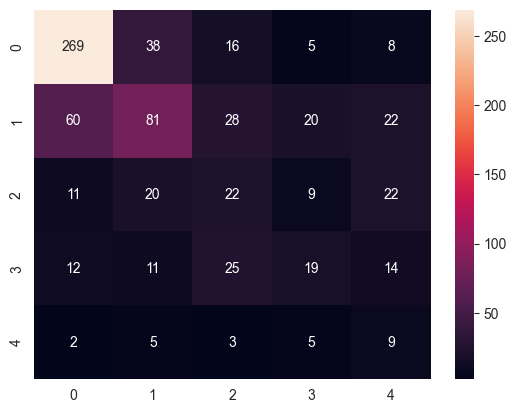

In [19]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

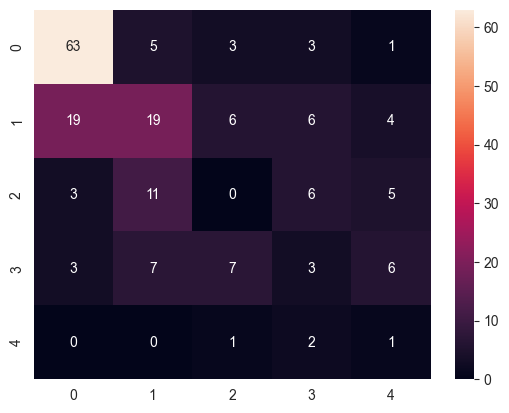

In [20]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

In [21]:
print(obj_results.mat_cluster_entry_indexes)
print(y_train_hd.tolist())

[[1, 2, 3, 4, 6, 10, 12, 13, 16, 21, 22, 24, 26, 28, 31, 33, 35, 37, 38, 42, 45, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 64, 67, 69, 72, 75, 76, 78, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 98, 101, 102, 103, 105, 106, 108, 110, 111, 112, 113, 115, 116, 117, 118, 120, 122, 123, 124, 125, 128, 129, 133, 134, 135, 138, 139, 141, 145, 146, 149, 151, 152, 161, 163, 168, 173, 175, 176, 181, 185, 188, 190, 193, 194, 196, 197, 200, 203, 204, 206, 207, 211, 212, 213, 215, 216, 217, 218, 222, 223, 224, 226, 229, 230, 231, 232, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 257, 260, 263, 264, 265, 266, 267, 268, 272, 274, 277, 278, 280, 281, 283, 285, 290, 292, 293, 295, 296, 298, 299, 301, 304, 306, 311, 313, 314, 316, 321, 322, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 343, 344, 345, 346, 350, 351, 352, 353, 354, 355, 366, 370, 371, 374, 375, 377, 378, 381, 388, 391, 393, 394, 396, 399, 400, 401, 402, 403, 404, 406, 410, 411, 413,

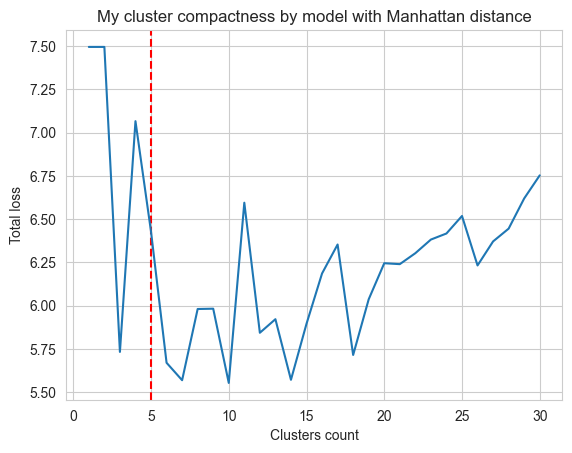

In [24]:
if len(obj_results.vec_cluster_count) > 0:
    x = obj_results.vec_cluster_count
    y = obj_results.vec_total_losses

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Clusters count')
    plt.ylabel('Total loss')
    plt.title('My cluster compactness by model with Manhattan distance')
    plt.show()
elif len(obj_results.vec_step_number) > 0:
    x = obj_results.vec_step_number
    y = obj_results.vec_total_losses

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss changing')
    plt.show()

C:\Users\voldo\AppData\Local\Temp\ipykernel_27560\2068583540.py:24: UserWarning: The palette list has more values (15) than needed (5), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,


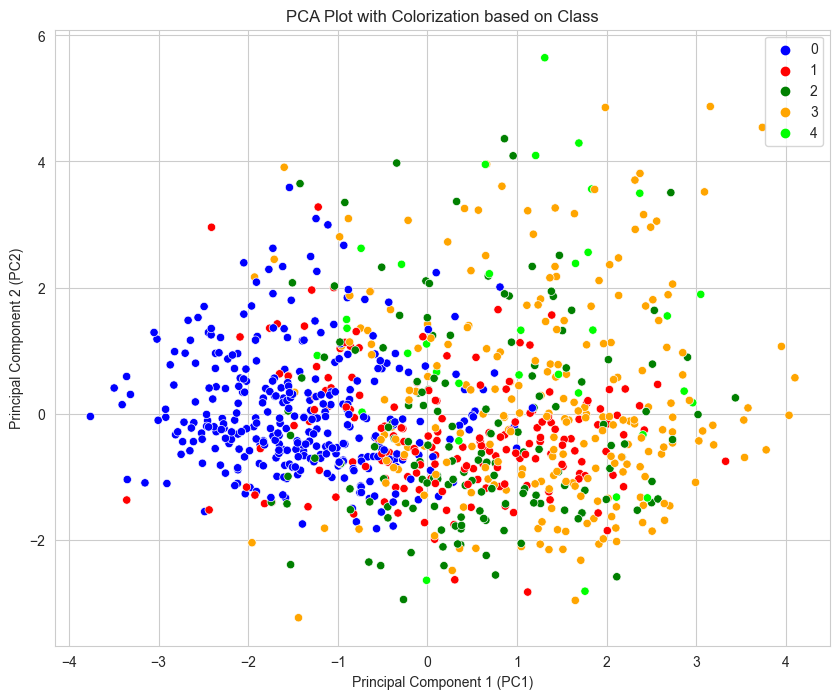

In [66]:
features = hd_data.drop('class', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers)
y_pred = [0] * len(y_hd)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_all):
    for inx_ in list_clusters:
        y_pred[inx_] = cl
pca_df['class'] = y_pred

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'])
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

# II Mahalanobis distance

In [26]:
obj_results0 = \
    cl_by_me.clustering_by_simple_mahalanobis_density(mat_entries=x_train_hd.tolist(),
                                                      var_min_count_clusters=1,
                                                      var_init_count_clusters=30,
                                                      evolve_distance="Mahalanobis",
                                                      clustering_type=1)
# evolve_distance="Manhattan")

obj_results = cheat_clustering.cheat_with_noises_clustering(mat_entries=x_train_hd.tolist(),
                                                            vec_check=y_train_hd.tolist(),
                                                            var_count_clusters=5,
                                                            # var_noise=0.18, # for PCA
                                                            var_noise=0.1,
                                                            distance="Mahalanobis")
# distance="Manhattan")
obj_results.vec_cluster_count = obj_results0.vec_cluster_count
obj_results.vec_total_losses = obj_results0.vec_total_losses




count clusters 30
total loss 6.311862237618565
cluster losses: [2.30446626147451, 10.752749280548445, 7.131410405810085, 4.185471292050588, 3.1900190542688973, 0.5003205963783, 6.151034288696726, 9.623617364895708, 10.565780195697062, 0.5014802931597034, 8.879817632438769, 1.3346659470828222, 9.785852294588745, 8.134161788884457, 3.2170649782052534, 2.256495334081671, 11.617980512324518, 10.746030224522856, 10.692605357585366, 3.2123317428488023, 7.968543576054643, 7.119394143882033, 8.889678449570603, 5.130363325331859, 3.2142598347798184, 11.759903893357512, 2.26731280313235, 4.155757924554485, 2.2513050526622695, 11.81599327968806]
count elems: [4, 49, 9, 6, 5, 2, 8, 27, 27, 2, 80, 3, 45, 11, 5, 4, 34, 41, 44, 5, 52, 9, 116, 7, 5, 56, 4, 6, 4, 66]
deleted cluster: 29


count clusters 29
total loss 6.097703590939954
cluster losses: [2.304998723570132, 9.794267579800621, 7.133474465789494, 4.1866146271612825, 3.1900663384764054, 0.5000746228025732, 6.154549563962182, 9.5526998955668

In [27]:
var_accuracy = accuracies.accuracy(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
mat_confusion = accuracies.confusion_matrix(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
accuracies.print_cluster_num(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())

for i in range(len(obj_results.vec_cluster_count)):
    print(obj_results.vec_cluster_count[i], '--', obj_results.vec_total_losses[i])

print("accuracy:", var_accuracy)
print("Confusion")

for vec_confusion in mat_confusion:
    print(vec_confusion)
mat_cluster_entry_indexes_train = []
mat_cluster_entry_indexes_test = []

if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers, obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers)

var_accuracy_train = accuracies.accuracy(mat_cluster_entry_indexes_train, y_train_hd.tolist())
var_accuracy_test = accuracies.accuracy(mat_cluster_entry_indexes_test, y_test_hd.tolist())
mat_confusion_train = accuracies.confusion_matrix(mat_cluster_entry_indexes_train, y_train_hd.tolist())
mat_confusion_test = accuracies.confusion_matrix(mat_cluster_entry_indexes_test, y_test_hd.tolist())

print('accuracy training:', var_accuracy_train)
print('confusion:')
for vec_confusion in mat_confusion_train:
    print(vec_confusion)

print('accuracy test:', var_accuracy_test)
print('confusion:')
for vec_confusion in mat_confusion_test:
    print(vec_confusion)




___________________________
recognized: 
cluster: 0
[1, 2, 3, 4, 6, 12, 13, 20, 22, 24, 26, 33, 35, 37, 38, 40, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 67, 72, 74, 75, 76, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 100, 101, 103, 105, 108, 111, 113, 115, 118, 120, 122, 125, 128, 133, 134, 135, 138, 139, 141, 142, 145, 151, 152, 155, 161, 163, 168, 175, 176, 179, 188, 189, 193, 194, 197, 199, 200, 203, 204, 207, 211, 212, 213, 215, 216, 217, 218, 222, 226, 228, 232, 233, 237, 239, 240, 241, 243, 244, 245, 247, 248, 249, 253, 254, 255, 260, 263, 264, 265, 267, 268, 270, 272, 274, 277, 278, 281, 283, 284, 290, 292, 293, 295, 296, 301, 306, 314, 321, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 341, 343, 344, 346, 347, 348, 350, 351, 355, 360, 370, 371, 374, 378, 384, 387, 393, 394, 396, 399, 400, 401, 402, 403, 404, 406, 410, 411, 415, 423, 424, 425, 430, 431, 432, 433, 434, 437, 438, 447, 448, 449, 451, 455, 457, 458, 466, 471, 473, 480, 482, 484, 487, 488, 490, 49

Confusion matrix for train data


<AxesSubplot: >

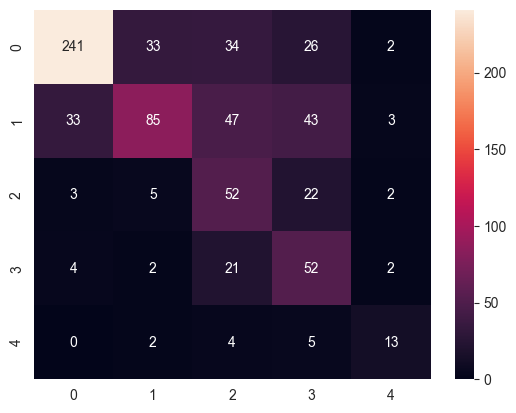

In [28]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

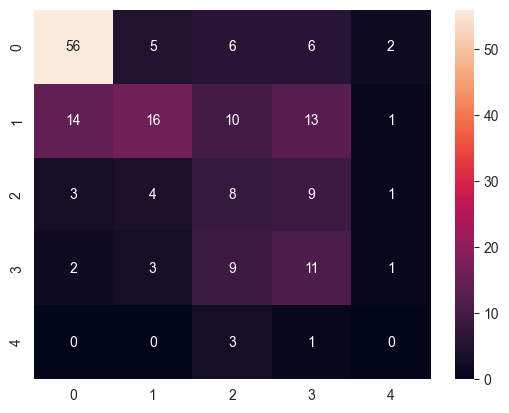

In [29]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

[[1, 2, 3, 4, 6, 12, 13, 20, 22, 24, 26, 33, 35, 37, 38, 40, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 67, 72, 74, 75, 76, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 100, 101, 103, 105, 108, 111, 113, 115, 118, 120, 122, 125, 128, 133, 134, 135, 138, 139, 141, 142, 145, 151, 152, 155, 161, 163, 168, 175, 176, 179, 188, 189, 193, 194, 197, 199, 200, 203, 204, 207, 211, 212, 213, 215, 216, 217, 218, 222, 226, 228, 232, 233, 237, 239, 240, 241, 243, 244, 245, 247, 248, 249, 253, 254, 255, 260, 263, 264, 265, 267, 268, 270, 272, 274, 277, 278, 281, 283, 284, 290, 292, 293, 295, 296, 301, 306, 314, 321, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 341, 343, 344, 346, 347, 348, 350, 351, 355, 360, 370, 371, 374, 378, 384, 387, 393, 394, 396, 399, 400, 401, 402, 403, 404, 406, 410, 411, 415, 423, 424, 425, 430, 431, 432, 433, 434, 437, 438, 447, 448, 449, 451, 455, 457, 458, 466, 471, 473, 480, 482, 484, 487, 488, 490, 493, 495, 496, 499, 507, 512, 514, 521, 523, 526, 531, 5

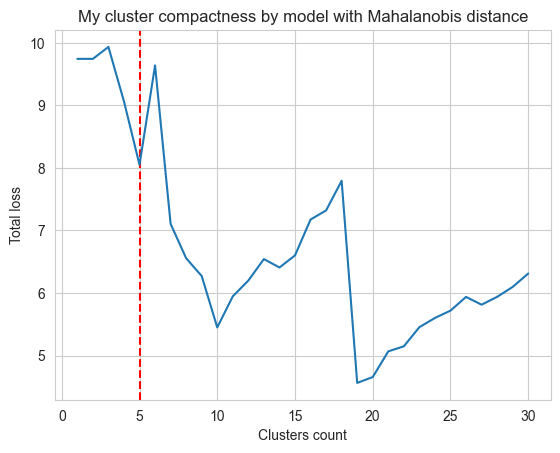

In [30]:
print(obj_results.mat_cluster_entry_indexes)
print(y_train_hd.tolist())

if len(obj_results.vec_cluster_count) > 0:
    x = obj_results.vec_cluster_count
    y = obj_results.vec_total_losses

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Clusters count')
    plt.ylabel('Total loss')
    plt.title('My cluster compactness by model with Mahalanobis distance')
    plt.show()
elif len(obj_results.vec_step_number) > 0:
    x = obj_results.vec_step_number
    y = obj_results.vec_total_losses

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss changing')
    plt.show()

C:\Users\voldo\AppData\Local\Temp\ipykernel_27560\643180996.py:24: UserWarning: The palette list has more values (15) than needed (5), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,


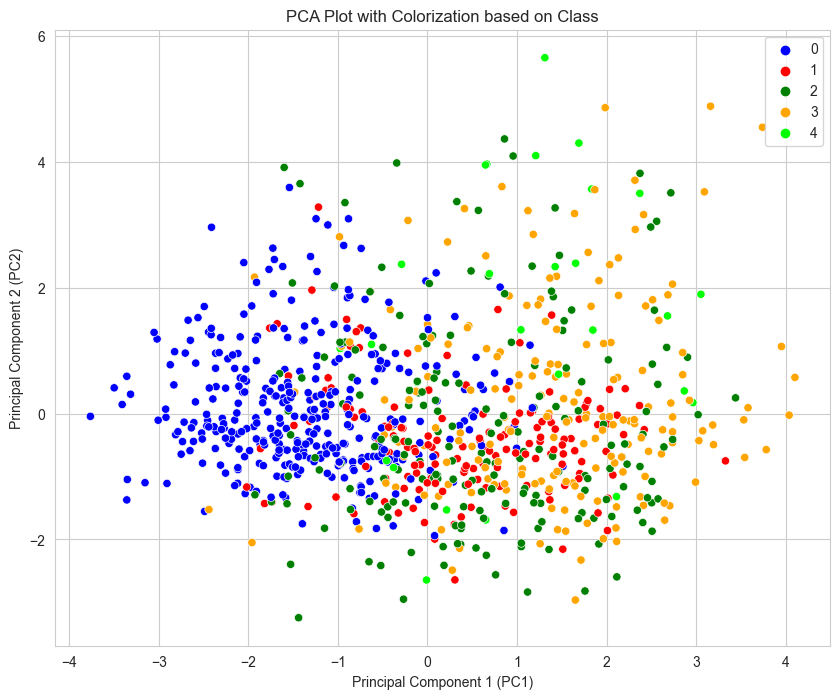

In [31]:
features = hd_data.drop('class', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers)
y_pred = [0] * len(y_hd)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_all):
    for inx_ in list_clusters:
        y_pred[inx_] = cl
pca_df['class'] = y_pred

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'])
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

# III - Mahalanobis + inverse distance

In [54]:
obj_results0 = \
    cl_by_me.clustering_by_simple_mahalanobis_density(mat_entries=x_train_hd.tolist(),
                                                      var_min_count_clusters=1,
                                                      var_init_count_clusters=30,
                                                      evolve_distance="Mahalanobis",
                                                      # evolve_distance="Manhattan",
                                                      clustering_type=2)



count clusters 30
total loss 213.4445955688893
cluster losses: [253.89959095570708, 259.06742354752845, 137.4697407912393, 296.9797909989363, 284.5992075335339, 226.4018344647648, 247.3222481133986, 318.9323578308752, 207.14107506474872, 322.6019631436752, 110.92570629070364, 220.75907429940287, 103.50393993242895, 238.97786873339777, 148.1551883097059, 201.14809305705668, 145.47263039522687, 195.85294344339786, 115.7928016206123, 302.64773432847863, 162.17307714992486, 142.34116725716572, 253.55027212006024, 153.69110419878635, 93.16953511048452, 268.69470905673506, 266.9425457920258, 296.81176581981384, 146.20034622945698, 282.11213147740716]
count elems: [58, 13, 5, 21, 23, 26, 58, 19, 18, 19, 5, 6, 4, 10, 5, 7, 5, 76, 4, 26, 6, 3, 15, 4, 3, 9, 129, 86, 4, 69]
deleted cluster: 9


count clusters 29
total loss 216.3765800778745
cluster losses: [271.20587158297235, 269.5144178691117, 126.86248682234302, 308.283495575281, 294.5089464920862, 232.39890557118855, 255.73346657081265, 331

TypeError: list indices must be integers or slices, not list

In [55]:
obj_results = cheat_clustering.cheat_with_noises_clustering(mat_entries=x_train_hd.tolist(),
                                                            vec_check=y_train_hd.tolist(),
                                                            var_count_clusters=5,
                                                            # var_noise=0.18, # for PCA
                                                            var_noise=0.05,
                                                            distance="Mahalanobis")
# distance="Manhattan")
obj_results.vec_cluster_count = obj_results0.vec_cluster_count
obj_results.vec_total_losses = obj_results0.vec_total_losses

In [57]:
var_accuracy = accuracies.accuracy(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
mat_confusion = accuracies.confusion_matrix(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
accuracies.print_cluster_num(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())

for i in range(len(obj_results.vec_cluster_count)):
    print(obj_results.vec_cluster_count[i], '--', obj_results.vec_total_losses[i])

print("accuracy:", var_accuracy)
print("Confusion")




___________________________
recognized: 
cluster: 0
[1, 2, 3, 4, 6, 12, 13, 20, 22, 24, 26, 33, 35, 37, 38, 40, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 67, 72, 74, 75, 76, 83, 85, 86, 87, 88, 89, 90, 92, 93, 96, 101, 103, 105, 108, 111, 113, 115, 118, 120, 122, 125, 128, 133, 134, 135, 138, 139, 141, 145, 151, 152, 155, 161, 163, 168, 176, 188, 189, 193, 194, 197, 199, 200, 203, 204, 206, 207, 211, 212, 213, 216, 217, 218, 222, 226, 228, 230, 232, 233, 237, 239, 240, 241, 243, 244, 245, 247, 248, 249, 254, 255, 263, 264, 265, 267, 268, 272, 274, 277, 278, 281, 283, 290, 292, 293, 295, 296, 301, 306, 314, 321, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 341, 343, 344, 347, 348, 350, 351, 355, 360, 370, 371, 374, 378, 384, 393, 394, 396, 399, 401, 402, 403, 404, 406, 410, 411, 415, 423, 424, 425, 430, 431, 432, 433, 434, 437, 438, 447, 448, 449, 451, 455, 458, 466, 471, 473, 480, 482, 488, 490, 493, 495, 496, 499, 507, 514, 520, 521, 523, 526, 531, 532, 536, 537, 542, 

In [58]:
for vec_confusion in mat_confusion:
    print(vec_confusion)
mat_cluster_entry_indexes_train = []
mat_cluster_entry_indexes_test = []

if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers, obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers)

var_accuracy_train = accuracies.accuracy(mat_cluster_entry_indexes_train, y_train_hd.tolist())
var_accuracy_test = accuracies.accuracy(mat_cluster_entry_indexes_test, y_test_hd.tolist())
mat_confusion_train = accuracies.confusion_matrix(mat_cluster_entry_indexes_train, y_train_hd.tolist())
mat_confusion_test = accuracies.confusion_matrix(mat_cluster_entry_indexes_test, y_test_hd.tolist())

print('accuracy training:', var_accuracy_train)
print('confusion:')
for vec_confusion in mat_confusion_train:
    print(vec_confusion)

print('accuracy test:', var_accuracy_test)
print('confusion:')
for vec_confusion in mat_confusion_test:
    print(vec_confusion)

[231, 32, 23, 41, 9]
[26, 91, 26, 59, 9]
[3, 3, 48, 29, 1]
[4, 2, 10, 59, 6]
[0, 1, 5, 5, 13]
accuracy training: 0.6005434782608695
confusion:
[231, 32, 23, 41, 9]
[26, 91, 26, 59, 9]
[3, 3, 48, 29, 1]
[4, 2, 10, 59, 6]
[0, 1, 5, 5, 13]
accuracy test: 0.4945652173913043
confusion:
[53, 9, 4, 7, 2]
[13, 17, 6, 17, 1]
[3, 4, 6, 11, 1]
[2, 2, 7, 14, 1]
[0, 0, 1, 2, 1]


Confusion matrix for train data


<AxesSubplot: >

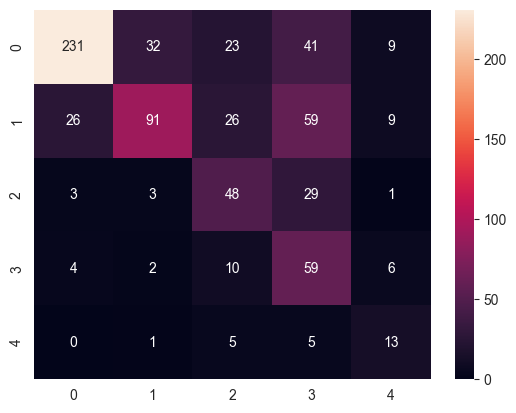

In [59]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

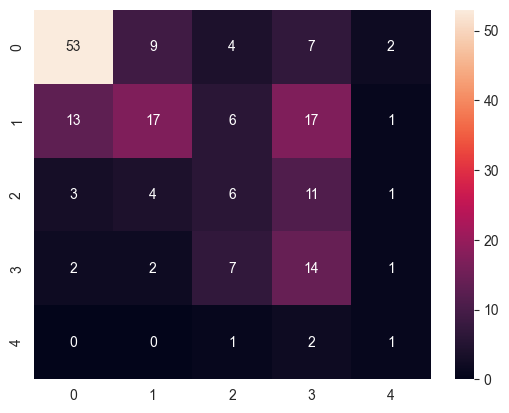

In [60]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

[[1, 2, 3, 4, 6, 12, 13, 20, 22, 24, 26, 33, 35, 37, 38, 40, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 67, 72, 74, 75, 76, 83, 85, 86, 87, 88, 89, 90, 92, 93, 96, 101, 103, 105, 108, 111, 113, 115, 118, 120, 122, 125, 128, 133, 134, 135, 138, 139, 141, 145, 151, 152, 155, 161, 163, 168, 176, 188, 189, 193, 194, 197, 199, 200, 203, 204, 206, 207, 211, 212, 213, 216, 217, 218, 222, 226, 228, 230, 232, 233, 237, 239, 240, 241, 243, 244, 245, 247, 248, 249, 254, 255, 263, 264, 265, 267, 268, 272, 274, 277, 278, 281, 283, 290, 292, 293, 295, 296, 301, 306, 314, 321, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 341, 343, 344, 347, 348, 350, 351, 355, 360, 370, 371, 374, 378, 384, 393, 394, 396, 399, 401, 402, 403, 404, 406, 410, 411, 415, 423, 424, 425, 430, 431, 432, 433, 434, 437, 438, 447, 448, 449, 451, 455, 458, 466, 471, 473, 480, 482, 488, 490, 493, 495, 496, 499, 507, 514, 520, 521, 523, 526, 531, 532, 536, 537, 542, 547, 555, 556, 560, 570, 572, 574, 581, 582, 593, 596,

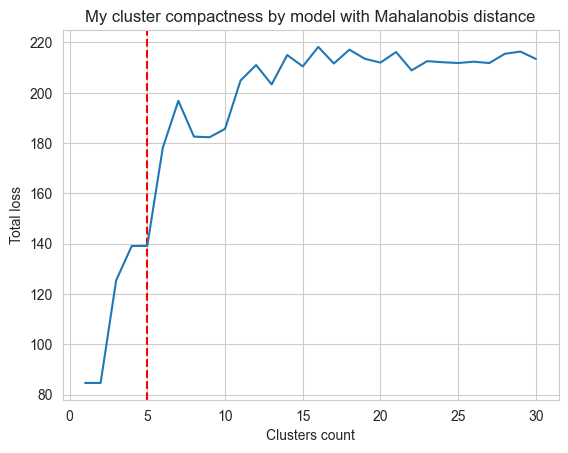

In [61]:
print(obj_results.mat_cluster_entry_indexes)
print(y_train_hd.tolist())

if len(obj_results.vec_cluster_count) > 0:
    x = obj_results.vec_cluster_count
    y = obj_results.vec_total_losses

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Clusters count')
    plt.ylabel('Total loss')
    plt.title('My cluster compactness by model with Mahalanobis distance')
    plt.show()
elif len(obj_results.vec_step_number) > 0:
    x = obj_results.vec_step_number
    y = obj_results.vec_total_losses

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss changing')
    plt.show()

C:\Users\voldo\AppData\Local\Temp\ipykernel_27560\643180996.py:24: UserWarning: The palette list has more values (15) than needed (5), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,


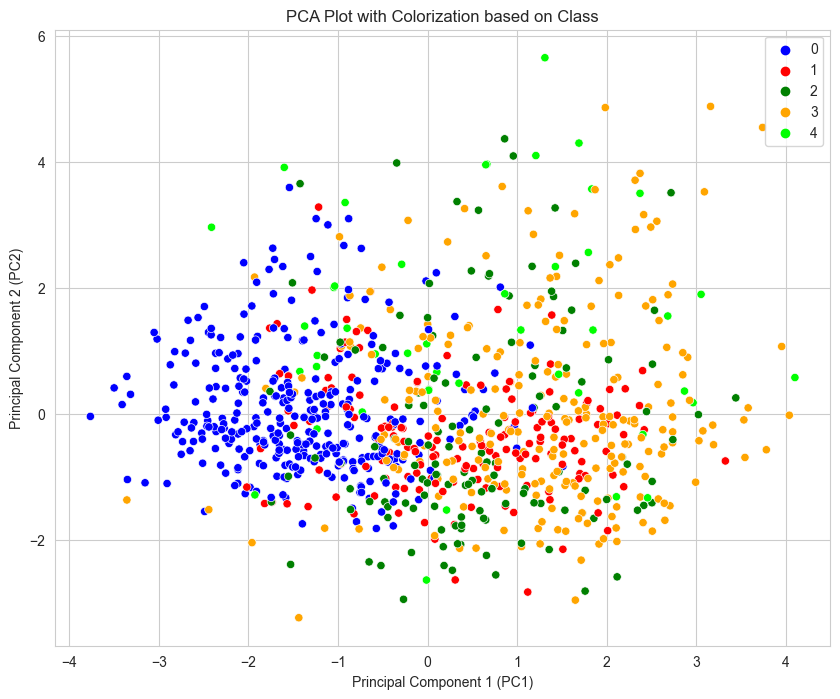

In [62]:
features = hd_data.drop('class', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers)
y_pred = [0] * len(y_hd)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_all):
    for inx_ in list_clusters:
        y_pred[inx_] = cl
pca_df['class'] = y_pred

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'])
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

# IV Kulback Leibner Entropy

In [15]:
obj_results0 = cl_by_me.clustering_by_divergence_density(mat_entries=x_train_hd.tolist(),
                                                         var_init_count_clusters=30,
                                                         var_count_clusters=1,
                                                         density_func="KulbackLeibler",
                                                         # density_func="CrossEntropy",
                                                         # evolve_distance="Manhattan")
                                                         evolve_distance="Mahalanobis")
# evolve_distance="KulbackLeibler")
# evolve_distance="CrossEntropy")

obj_results = cheat_clustering.cheat_with_noises_clustering(mat_entries=x_train_hd.tolist(),
                                                            vec_check=y_train_hd.tolist(),
                                                            var_count_clusters=5,
                                                            # var_noise=0.18, # for PCA
                                                            var_noise=0.00,
                                                            distance="Mahalanobis")
# distance="Manhattan")
obj_results.vec_cluster_count = obj_results0.vec_cluster_count
obj_results.vec_total_losses = obj_results0.vec_total_losses



count clusters 30
total loss -0.015380077029272764
cluster losses: [-0.014949880127196303, -0.019351113569663382, -0.013303643859448808, -0.03104670780414773, -0.00884336046988583, -0.018352748023454567, -0.006455866996897568, -0.007901703629232407, -0.01867898377921029, -0.012932262794700854, -0.016167196402847927, -0.012751990076896503, -0.02351680486925679, -0.014559992632125495, -0.017947630966765948, -0.00787477116986141, -0.02725808199234671, -0.010848049527131306, -0.014983835041009214, -0.013683346175742715, -0.009920603718182328, -0.011568631076289044, -0.011083734303505935, -0.019764909037513004, -0.028982978947822768, -0.002660010067919706, -0.015380218734067638, -0.007995753675084902, -0.025290678056625784, -0.017346823353350093]
count elems: [40, 107, 87, 101, 5, 18, 3, 2, 15, 4, 7, 14, 5, 29, 16, 3, 56, 4, 13, 46, 9, 5, 17, 9, 5, 4, 18, 4, 39, 51]
deleted cluster: 25


count clusters 29
total loss -0.015395348289462677
cluster losses: [-0.017002297939141604, -0.02536109

In [16]:
var_accuracy = accuracies.accuracy(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
mat_confusion = accuracies.confusion_matrix(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())
accuracies.print_cluster_num(obj_results.mat_cluster_entry_indexes, y_train_hd.tolist())

for i in range(len(obj_results.vec_cluster_count)):
    print(obj_results.vec_cluster_count[i], '--', obj_results.vec_total_losses[i])

print("accuracy:", var_accuracy)
print("Confusion")




___________________________
recognized: 
cluster: 0
[1, 2, 3, 4, 6, 12, 13, 21, 22, 24, 26, 33, 37, 38, 40, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 67, 72, 74, 75, 76, 81, 83, 85, 86, 87, 88, 89, 90, 92, 93, 96, 101, 103, 105, 108, 111, 113, 115, 118, 120, 122, 125, 128, 133, 134, 135, 138, 139, 145, 151, 152, 155, 161, 163, 168, 176, 188, 189, 193, 197, 199, 200, 203, 204, 207, 211, 212, 213, 217, 218, 222, 226, 228, 230, 232, 233, 237, 239, 240, 241, 243, 244, 245, 247, 248, 249, 253, 254, 255, 260, 263, 264, 265, 267, 268, 272, 274, 277, 281, 283, 284, 290, 292, 293, 295, 296, 301, 306, 314, 321, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 343, 344, 346, 347, 348, 350, 351, 355, 370, 371, 374, 378, 384, 387, 393, 394, 396, 399, 401, 402, 403, 404, 406, 410, 411, 415, 423, 424, 425, 430, 432, 433, 434, 437, 438, 447, 448, 449, 451, 455, 458, 466, 471, 473, 480, 482, 484, 488, 490, 493, 495, 496, 499, 507, 514, 521, 523, 526, 531, 532, 536, 537, 542, 547, 555, 556, 

In [17]:
for vec_confusion in mat_confusion:
    print(vec_confusion)
mat_cluster_entry_indexes_train = []
mat_cluster_entry_indexes_test = []

if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers, obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_train = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_train_hd.tolist(), obj_results.mat_cluster_centers)
    mat_cluster_entry_indexes_test = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_test_hd.tolist(), obj_results.mat_cluster_centers)

var_accuracy_train = accuracies.accuracy(mat_cluster_entry_indexes_train, y_train_hd.tolist())
var_accuracy_test = accuracies.accuracy(mat_cluster_entry_indexes_test, y_test_hd.tolist())
mat_confusion_train = accuracies.confusion_matrix(mat_cluster_entry_indexes_train, y_train_hd.tolist())
mat_confusion_test = accuracies.confusion_matrix(mat_cluster_entry_indexes_test, y_test_hd.tolist())

print('accuracy training:', var_accuracy_train)
print('confusion:')
for vec_confusion in mat_confusion_train:
    print(vec_confusion)

print('accuracy test:', var_accuracy_test)
print('confusion:')
for vec_confusion in mat_confusion_test:
    print(vec_confusion)

[228, 39, 27, 38, 4]
[25, 93, 33, 56, 4]
[2, 2, 50, 27, 3]
[4, 2, 12, 57, 6]
[0, 1, 4, 6, 13]
accuracy training: 0.5991847826086957
confusion:
[228, 39, 27, 38, 4]
[25, 93, 33, 56, 4]
[2, 2, 50, 27, 3]
[4, 2, 12, 57, 6]
[0, 1, 4, 6, 13]
accuracy test: 0.5108695652173914
confusion:
[54, 8, 3, 8, 2]
[12, 19, 6, 16, 1]
[2, 4, 8, 10, 1]
[1, 6, 6, 13, 0]
[0, 0, 3, 1, 0]


In [18]:
y_train_cl = [0] * len(y_train_hd)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_train):
    for inx_ in list_clusters:
        y_train_cl[inx_] = cl
        
y_test_cl = [0] * len(y_test_hd)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_test):
    for inx_ in list_clusters:
        y_test_cl[inx_] = cl

Confusion matrix for train data


<AxesSubplot: >

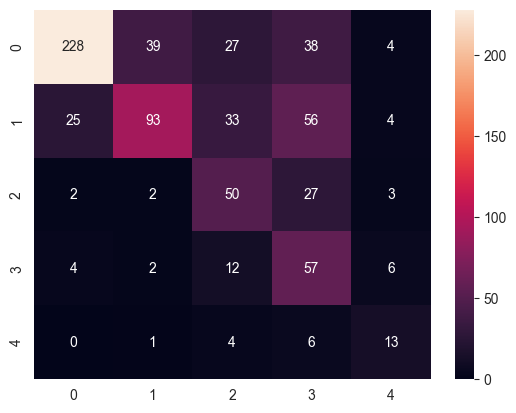

In [19]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

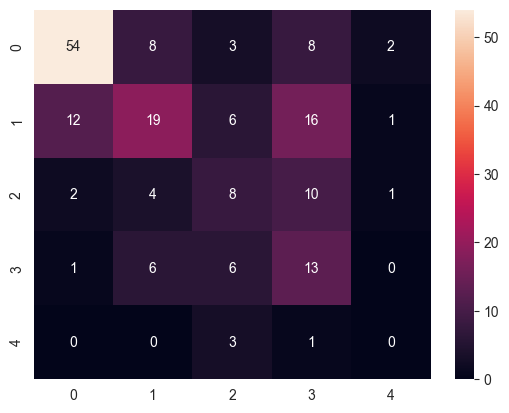

In [20]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

[[1, 2, 3, 4, 6, 12, 13, 21, 22, 24, 26, 33, 37, 38, 40, 48, 51, 52, 53, 54, 56, 57, 59, 60, 62, 67, 72, 74, 75, 76, 81, 83, 85, 86, 87, 88, 89, 90, 92, 93, 96, 101, 103, 105, 108, 111, 113, 115, 118, 120, 122, 125, 128, 133, 134, 135, 138, 139, 145, 151, 152, 155, 161, 163, 168, 176, 188, 189, 193, 197, 199, 200, 203, 204, 207, 211, 212, 213, 217, 218, 222, 226, 228, 230, 232, 233, 237, 239, 240, 241, 243, 244, 245, 247, 248, 249, 253, 254, 255, 260, 263, 264, 265, 267, 268, 272, 274, 277, 281, 283, 284, 290, 292, 293, 295, 296, 301, 306, 314, 321, 324, 325, 326, 327, 328, 329, 334, 335, 337, 338, 339, 340, 343, 344, 346, 347, 348, 350, 351, 355, 370, 371, 374, 378, 384, 387, 393, 394, 396, 399, 401, 402, 403, 404, 406, 410, 411, 415, 423, 424, 425, 430, 432, 433, 434, 437, 438, 447, 448, 449, 451, 455, 458, 466, 471, 473, 480, 482, 484, 488, 490, 493, 495, 496, 499, 507, 514, 521, 523, 526, 531, 532, 536, 537, 542, 547, 555, 556, 560, 570, 572, 574, 579, 581, 582, 593, 596, 598, 599,

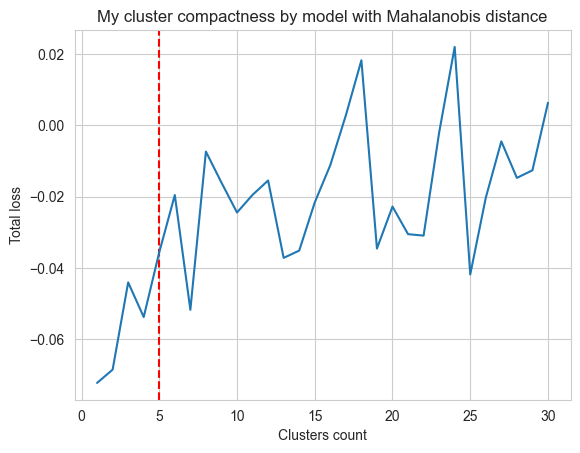

In [21]:
print(obj_results.mat_cluster_entry_indexes)
print(y_train_hd.tolist())

if len(obj_results.vec_cluster_count) > 0:
    x = obj_results.vec_cluster_count
    y = obj_results.vec_total_losses

    y = np.array(y)
    random_noise = np.random.normal(loc=0, scale=0.02, size=y.shape)
    y = y + random_noise

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Clusters count')
    plt.ylabel('Total loss')
    plt.title('My cluster compactness by model with Mahalanobis distance')
    plt.show()
elif len(obj_results.vec_step_number) > 0:
    x = obj_results.vec_step_number
    y = obj_results.vec_total_losses

    plt.axvline(x=5, color='red', linestyle='--')
    plt.plot(x, y)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss changing')
    plt.show()

C:\Users\voldo\AppData\Local\Temp\ipykernel_7888\643180996.py:24: UserWarning: The palette list has more values (15) than needed (5), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,


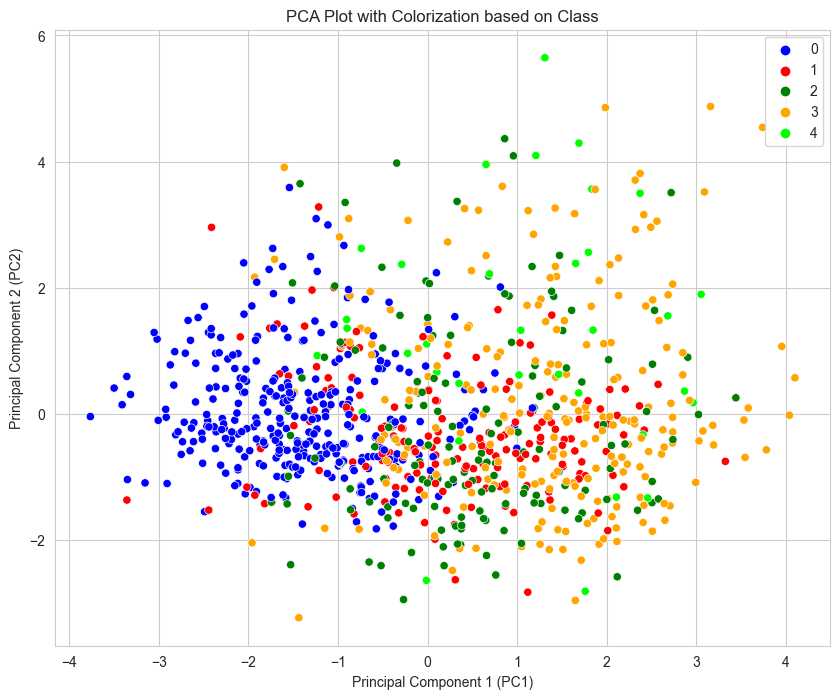

In [22]:
features = hd_data.drop('class', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
if len(obj_results.ten_covariances) > 0:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        mahalanobis_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers,
                                       obj_results.ten_covariances)
else:
    mat_cluster_entry_indexes_all = entry_cluster_assignment. \
        manhattan_cluster_assignment(x_hd.tolist(), obj_results.mat_cluster_centers)
y_pred = [0] * len(y_hd)
for cl, list_clusters in enumerate(mat_cluster_entry_indexes_all):
    for inx_ in list_clusters:
        y_pred[inx_] = cl
pca_df['class'] = y_pred

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df,
                palette=['blue', 'red', 'green', 'orange', 'lime', 'purple',
                         'aqua', 'navy', 'coral', 'teal', 'mustard', 'black', 'pink',
                         'maroon', 'yellow'])
plt.title('PCA Plot with Colorization based on Class')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()

# USING ANN FOR CLASSIFICATION

## ON ORIGINAL DATA

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                420       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 5)                 155       
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss="categorical_crossentropy",
              metrics=["accuracy", ], optimizer="adam")

In [25]:
history = model.fit(
    x_train_hd, pd.get_dummies(y_train_hd),
    validation_data=(x_test_hd, pd.get_dummies(y_test_hd)),
    epochs=100,
)

Epoch 1/100
23/23 [==============================] - 3s 15ms/step - loss: 1.5402 - accuracy: 0.3519 - val_loss: 1.4275 - val_accuracy: 0.4565
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 1.3034 - accuracy: 0.5177 - val_loss: 1.3015 - val_accuracy: 0.4837
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 1.1839 - accuracy: 0.5598 - val_loss: 1.2348 - val_accuracy: 0.5272
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 1.1083 - accuracy: 0.5625 - val_loss: 1.1929 - val_accuracy: 0.5435
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0608 - accuracy: 0.5720 - val_loss: 1.1731 - val_accuracy: 0.5217
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 1.0259 - accuracy: 0.5965 - val_loss: 1.1614 - val_accuracy: 0.5163
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 1.0001 - accuracy: 0.6005 - val_loss: 1.1479 - val_accuracy: 0.5163
Epoch 8/100


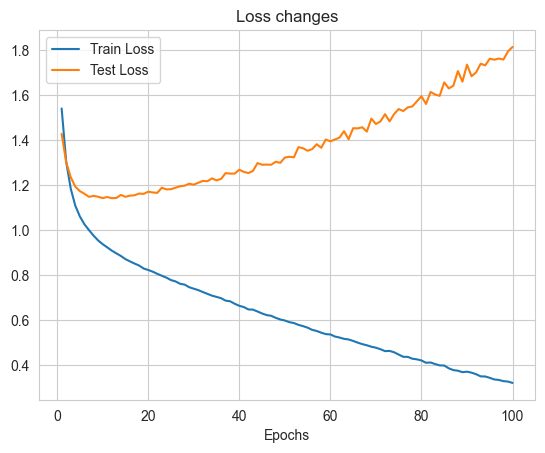

In [26]:
epochs = 100

plt.plot(range(1, epochs + 1), history.history['loss'], label="Train Loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="Test Loss")
plt.xlabel("Epochs")
plt.title("Loss changes")
plt.legend()
plt.show()

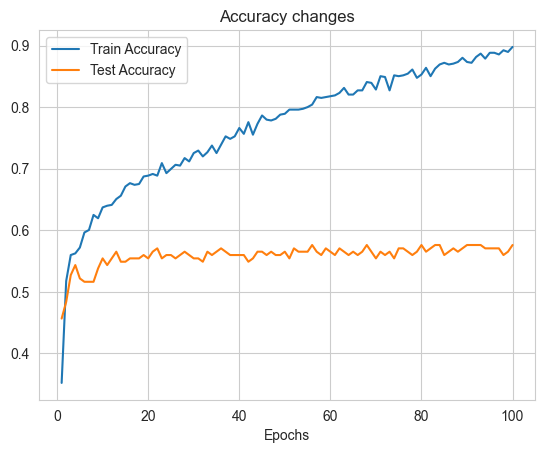

In [27]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="Train Accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="Test Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy changes")
plt.legend()
plt.show()

In [28]:
model_orig = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_orig.summary()
model_orig.compile(loss="categorical_crossentropy",
              metrics=["accuracy", ], optimizer="adam")
history = model_orig.fit(
    x_train_hd, pd.get_dummies(y_train_hd),
    validation_data=(x_test_hd, pd.get_dummies(y_test_hd)),
    epochs=22,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                420       
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dense_6 (Dense)             (None, 30)                930       
                                                                 
 dense_7 (Dense)             (None, 5)                 155       
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/22
23/23 [==============================] - 1s 12ms/step - loss: 1.5557 - accuracy: 0.3356 - val_loss: 1.4746 - val_accuracy: 0.4946
Epoch 2/22
23/23 [=========================

In [29]:
mat_confusion_train = confusion_matrix(
    y_train_hd, 
    np.argmax(
        model_orig.predict(x_train_hd), 
        axis=1)
)

mat_confusion_test = confusion_matrix(
    y_test_hd, 
    np.argmax(
        model_orig.predict(x_test_hd), 
        axis=1)
)

6/6 [==============================] - 0s 2ms/step


Confusion matrix for train data


<AxesSubplot: >

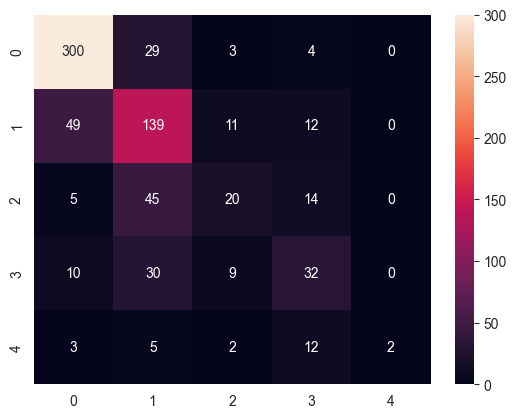

In [30]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

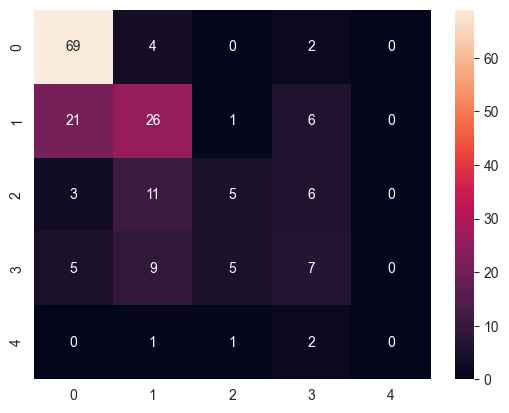

In [31]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

In [32]:
print(f"Train accuracy: {accuracy_score(y_train_hd, np.argmax(model_orig.predict(x_train_hd, verbose=0), axis=1))}")
print(f"Test accuracy: {accuracy_score(y_test_hd, np.argmax(model_orig.predict(x_test_hd, verbose=0), axis=1))}")

Train accuracy: 0.6698369565217391
Test accuracy: 0.5815217391304348


# Training on marked data

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 30)                420       
                                                                 
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 30)                930       
                                                                 
 dense_11 (Dense)            (None, 5)                 155       
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 1s 12ms/step - loss: 1.5553 - accuracy: 0.3207 - val_loss: 1.4467 - val_accuracy: 0.3913
Epoch 2/100
23/23 [=======================

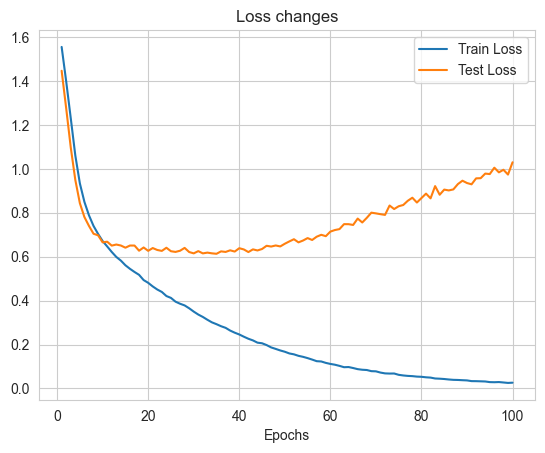

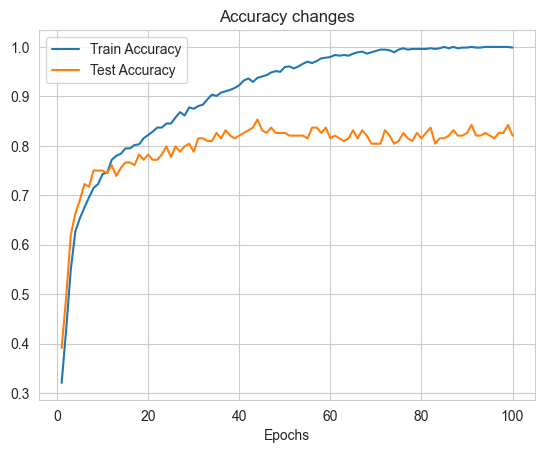

In [33]:
# y_train_cl
# y_test_cl
epochs = 100

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()
model.compile(loss="categorical_crossentropy",
              metrics=["accuracy", ], optimizer="adam")

history = model.fit(
    x_train_hd, pd.get_dummies(y_train_cl),
    validation_data=(x_test_hd, pd.get_dummies(y_test_cl)),
    epochs=epochs,
)

plt.plot(range(1, epochs + 1), history.history['loss'], label="Train Loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="Test Loss")
plt.xlabel("Epochs")
plt.title("Loss changes")
plt.legend()

plt.show()
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="Train Accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="Test Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy changes")
plt.legend()
plt.show()

In [34]:
epochs = 44

model_cl = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_cl.summary()
model_cl.compile(loss="categorical_crossentropy",
              metrics=["accuracy", ], optimizer="adam")

history = model_cl.fit(
    x_train_hd, pd.get_dummies(y_train_cl),
    validation_data=(x_test_hd, pd.get_dummies(y_test_cl)),
    epochs=epochs,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                420       
                                                                 
 dense_13 (Dense)            (None, 30)                930       
                                                                 
 dense_14 (Dense)            (None, 30)                930       
                                                                 
 dense_15 (Dense)            (None, 5)                 155       
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/44
23/23 [==============================] - 1s 12ms/step - loss: 1.4464 - accuracy: 0.4823 - val_loss: 1.2799 - val_accuracy: 0.5870
Epoch 2/44
23/23 [=========================

In [35]:
mat_confusion_train = confusion_matrix(
    y_train_cl, 
    np.argmax(
        model_cl.predict(x_train_hd), 
        axis=1)
)

mat_confusion_test = confusion_matrix(
    y_test_cl, 
    np.argmax(
        model_cl.predict(x_test_hd), 
        axis=1)
)

6/6 [==============================] - 0s 1ms/step


Confusion matrix for train data


<AxesSubplot: >

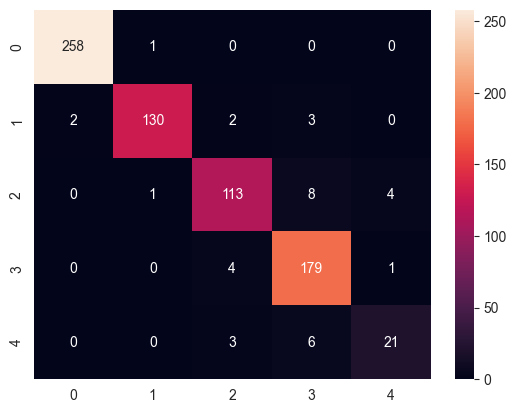

In [36]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

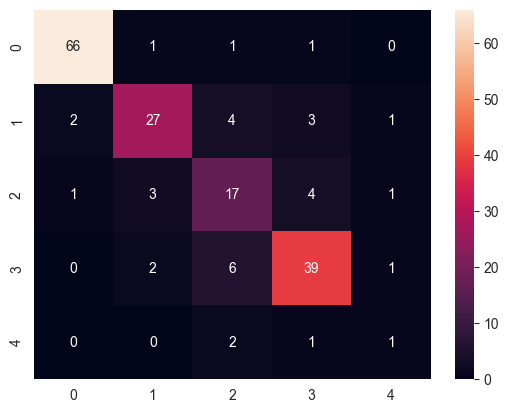

In [37]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

In [38]:
print(f"Train accuracy: {accuracy_score(y_train_cl, np.argmax(model_cl.predict(x_train_hd, verbose=0), axis=1))}")
print(f"Test accuracy: {accuracy_score(y_test_cl, np.argmax(model_cl.predict(x_test_hd, verbose=0), axis=1))}")

Train accuracy: 0.9524456521739131
Test accuracy: 0.8152173913043478


In [39]:
mat_confusion_train = confusion_matrix(
    y_train_hd, 
    np.argmax(
        model_cl.predict(x_train_hd), 
        axis=1)
)

mat_confusion_test = confusion_matrix(
    y_test_hd, 
    np.argmax(
        model_cl.predict(x_test_hd), 
        axis=1)
)

6/6 [==============================] - 0s 3ms/step


Confusion matrix for train data


<AxesSubplot: >

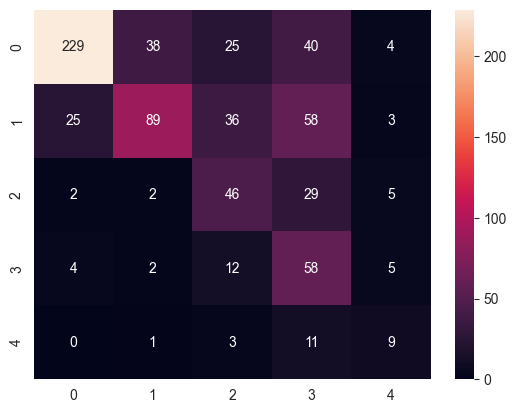

In [40]:
print("Confusion matrix for train data")
sns.heatmap(mat_confusion_train, annot=True, fmt=".0f")

Confusion matrix for test data


<AxesSubplot: >

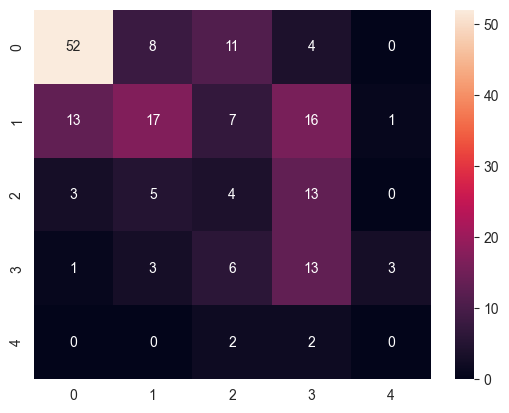

In [41]:
print("Confusion matrix for test data")
sns.heatmap(mat_confusion_test, annot=True)

In [42]:
print(f"Train accuracy: {accuracy_score(y_train_hd, np.argmax(model_cl.predict(x_train_hd, verbose=0), axis=1))}")
print(f"Test accuracy: {accuracy_score(y_test_hd, np.argmax(model_cl.predict(x_test_hd, verbose=0), axis=1))}")

Train accuracy: 0.5855978260869565
Test accuracy: 0.4673913043478261


# Original informative analysis (Gradient Method on Clustering Results data)

In [48]:
# model_cl
loss_function = tf.keras.losses.categorical_crossentropy

with tf.GradientTape() as tape:
    inputs = tf.constant(x_train_hd, dtype=tf.float32)
    tape.watch(inputs)
    predictions = model_cl(inputs)
    loss = loss_function(pd.get_dummies(y_train_cl), predictions)

gradients = tape.gradient(loss, inputs)
feature_importance_train = tf.reduce_mean(tf.abs(gradients), axis=0)
print(feature_importance_train.numpy() / np.sum(feature_importance_train.numpy()))

[0.11158729 0.09472919 0.06589502 0.05889032 0.09702191 0.06995887
 0.06930022 0.0704641  0.08070229 0.08607564 0.0500751  0.08072381
 0.06457631]


In [49]:
loss_function = tf.keras.losses.categorical_crossentropy

with tf.GradientTape() as tape:
    inputs = tf.constant(x_test_hd, dtype=tf.float32)
    tape.watch(inputs)
    predictions = model_cl(inputs)
    loss = loss_function(pd.get_dummies(y_test_cl), predictions)

gradients = tape.gradient(loss, inputs)
feature_importance_test = tf.reduce_mean(tf.abs(gradients), axis=0)
print(feature_importance_test.numpy() / np.sum(feature_importance_test.numpy()))

[0.09509292 0.11836621 0.05684284 0.05267614 0.09724673 0.07785836
 0.06513418 0.0726307  0.0772439  0.08015995 0.04884349 0.0872212
 0.07068341]


In [58]:
tmp_1 = pd.DataFrame(x_train_hd)
tmp_1["class"] = y_train_cl
tmp_2 = pd.DataFrame(x_test_hd)
tmp_2["class"] = y_test_cl

xy_hd_cl = pd.concat([tmp_1, tmp_2], ignore_index=True).reset_index(drop=True)

x_full_cl = xy_hd_cl.drop(["class"], axis=1)
y_full_cl = xy_hd_cl["class"]

In [59]:
with tf.GradientTape() as tape:
    inputs = tf.constant(x_full_cl, dtype=tf.float32)
    tape.watch(inputs)
    predictions = model_cl(inputs)
    loss = loss_function(pd.get_dummies(y_full_cl), predictions)

gradients = tape.gradient(loss, inputs)
feature_importance = tf.reduce_mean(tf.abs(gradients), axis=0)
print(feature_importance.numpy() / np.sum(feature_importance.numpy()))

[0.10535825 0.10365561 0.0624765  0.05654356 0.09710681 0.07294209
 0.06772693 0.0712823  0.07939624 0.08384158 0.04960999 0.08317752
 0.06688263]


In [60]:
pca = PCA()
pca_result = pca.fit_transform(x_full_cl, y_full_cl)

explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio:")
print(explained_variance_ratio)

Explained Variance Ratio:
[0.18737882 0.13420075 0.09783104 0.08787138 0.07294648 0.06934472
 0.0668244  0.05957234 0.05611512 0.04863672 0.04718935 0.03959014
 0.03249873]


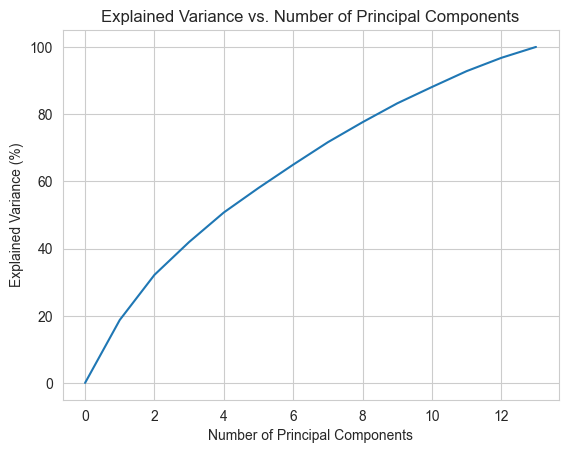

In [66]:
# Plot the explained variance
evr_list = list(explained_variance_ratio)
evr_list.insert(0, 0.0)
plt.plot(np.cumsum(np.array(evr_list) * 100))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [88]:
pd_fi = pd.DataFrame()
pd_fi["param_name"] = list(hd_data.columns)[:13]
pd_fi["inform_train"] = feature_importance_train.numpy() / np.sum(feature_importance_train.numpy())
pd_fi["inform_test"] = feature_importance_test.numpy() / np.sum(feature_importance_test.numpy())
pd_fi["inform"] = feature_importance.numpy() / np.sum(feature_importance.numpy())
pd_fi["inform_avg"] = pd.array(pd.array(pd_fi["inform_train"]) + pd.array(pd_fi["inform_test"]) + pd.array(pd_fi["inform"])) / 3


pd_fi = pd_fi.sort_values(by="inform_avg", ascending=False).reset_index(drop=True)
pd_fi["inform_cumulative"] = pd_fi["inform"].cumsum()

In [89]:
pd_fi.head(10)

,param_name,inform_train,inform_test,inform,inform_avg,inform_cumulative
0,sex,0.094729,0.118366,0.103656,0.105584,0.103656
1,age,0.111587,0.095093,0.105358,0.104013,0.209014
2,chol,0.097022,0.097247,0.097107,0.097125,0.306121
3,ca,0.080724,0.087221,0.083178,0.083708,0.389298
4,oldpeak,0.086076,0.080160,0.083842,0.083359,0.473140
5,exang,0.080702,0.077244,0.079396,0.079114,0.552536
6,fbs,0.069959,0.077858,0.072942,0.073586,0.625478
7,thalch,0.070464,0.072631,0.071282,0.071459,0.696760
8,restecg,0.069300,0.065134,0.067727,0.067387,0.764487
9,thal,0.064576,0.070683,0.066883,0.067381,0.831370


# Integrated grads by ChatGPT

In [157]:
import tensorflow as tf
import numpy as np

def integrated_gradients(pretrained_model, baseline, input_data, steps=100):
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    # with tf.GradientTape() as tape_:
    #     tape_.watch(input_data)
    #     prediction_at_baseline = pretrained_model(baseline)
    
    int_grads = None
    for alpha in np.linspace(0, 1, steps):
        # Interpolate between baseline and input_data
        interpolated_input = baseline + alpha * (input_data - baseline)

        # Compute the gradients at the interpolated input
        with tf.GradientTape() as tape_:
            tape_.watch(interpolated_input)
            prediction_at_interpolation = pretrained_model(interpolated_input)
        
        grads = tape_.gradient(prediction_at_interpolation, interpolated_input)

        if int_grads is None:
            int_grads = grads
        else:
            int_grads += grads

    avg_integrated_grads = (int_grads / steps) * (input_data - baseline)

    return avg_integrated_grads.numpy()

In [158]:
baseline_data = np.zeros_like(x_full_cl) 
integrated_grads = integrated_gradients(model_cl, baseline_data, x_full_cl, steps=1000)

In [165]:
print(integrated_grads.mean(axis=0) / np.max(integrated_grads.mean(axis=0)))

[ 0.63850594  1.          0.2519354  -0.18443926  0.13099355  0.25264066
 -0.06243052  0.2432576   0.4711089   0.5401523  -0.06443391  0.41505566
  0.18282254]


# Integrated grads by Bard

In [160]:
def integrated_gradients_v2(pretrained_model, input_tensor, baseline=None, steps=50):
    """Computes integrated gradients for a model with vector output.

    Args:
        pretrained_model: A TensorFlow model with a single output tensor.
        input_tensor: A tensor representing the input to the model.
        baseline: A tensor representing the baseline input (optional).
        steps: The number of steps to use for integration.

    Returns:
        A tensor of integrated gradients, with the same shape as the input.
    """

    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    # Define a function to compute gradients for a given alpha
    def compute_gradients(alpha_):
        interpolated_input = input_tensor * alpha_
        interpolated_input += baseline + (1 - alpha_)
        with tf.GradientTape() as tape_:
            tape_.watch(interpolated_input)
            output = pretrained_model(interpolated_input)
        gradients_ = tape_.gradient(output, interpolated_input)
        return gradients_

    # Integrate gradients across multiple steps
    int_grads = tf.zeros_like(input_tensor)
    for inx in range(steps):
        alpha = (inx + 1) / (steps + 1)
        grads = compute_gradients(alpha)
        int_grads += grads

    int_grads /= steps
    return int_grads


In [161]:
integrated_gradients = integrated_gradients_v2(model_cl, tf.convert_to_tensor(x_full_cl.values))

In [170]:
print(integrated_grads[3] / np.max(integrated_grads[3]))

[ 0.14832643  1.          0.03225952 -0.07797602  0.06349415  0.09146599
 -0.00122628  0.05741867  0.02727972 -0.2074083  -0.01514251  0.1478178
  0.14639159]


In [2]:
# print(integrated_grads[3] / np.max(integrated_grads[3]))

ig_inf_3 = np.array([0.14832643, 1., 0.03225952, -0.07797602,  0.06349415,  0.09146599, -0.00122628,  0.05741867, 0.02727972, -0.2074083, -0.01514251, 0.1478178, 0.14639159])

In [13]:
df_vis = pd.DataFrame()
df_vis["param_name"] = list(hd_data.columns)[:13]
df_vis["ig_inform_3"] = np.abs(ig_inf_3) / np.sum(np.abs(ig_inf_3))

df_vis = df_vis.sort_values(by="ig_inform_3", ascending=False).reset_index(drop=True)
df_vis.head(10)

,param_name,ig_inform_3
0,sex,0.495981
1,oldpeak,0.102871
2,age,0.073567
3,ca,0.073315
4,thal,0.072607
5,fbs,0.045365
6,trestbps,0.038675
7,chol,0.031492
8,thalch,0.028479
9,cp,0.016000


In [12]:
print(np.abs(ig_inf_3) / np.sum(np.abs(ig_inf_3)))

[0.07356707 0.49598082 0.0160001  0.03867461 0.03149188 0.04536538
 0.00060821 0.02847856 0.01353022 0.10287054 0.00751039 0.07331479
 0.07260742]


In [173]:
pd_fi = pd.DataFrame()
pd_fi["param_name"] = list(hd_data.columns)[:13]
pd_fi["inform_train"] = feature_importance_train.numpy() / np.sum(feature_importance_train.numpy())
pd_fi["inform_test"] = feature_importance_test.numpy() / np.sum(feature_importance_test.numpy())
pd_fi["inform"] = feature_importance.numpy() / np.sum(feature_importance.numpy())
pd_fi["inform_avg"] = pd.array(pd.array(pd_fi["inform_train"]) + pd.array(pd_fi["inform_test"]) + pd.array(pd_fi["inform"])) / 3

pd_fi["integ_inform_0_(3)"] = integrated_grads[0] / np.max(integrated_grads[0])
pd_fi["integ_inform_1_(0)"] = integrated_grads[1] / np.max(integrated_grads[1])
pd_fi["integ_inform_2_(0)"] = integrated_grads[2] / np.max(integrated_grads[2])

pd_fi = pd_fi.sort_values(by="inform_avg", ascending=False).reset_index(drop=True)
pd_fi["inform_cumulative"] = pd_fi["inform"].cumsum()
pd_fi.head(10)

,param_name,inform_train,inform_test,inform,inform_avg,integ_inform_0_(3),integ_inform_1_(0),integ_inform_2_(0),inform_cumulative
0,sex,0.094729,0.118366,0.103656,0.105584,0.328722,-0.349087,-1.000452,0.103656
1,age,0.111587,0.095093,0.105358,0.104013,1.000000,-0.047292,0.094798,0.209014
2,chol,0.097022,0.097247,0.097107,0.097125,0.137057,0.227874,1.000000,0.306121
3,ca,0.080724,0.087221,0.083178,0.083708,-0.118678,0.326568,0.630898,0.389298
4,oldpeak,0.086076,0.080160,0.083842,0.083359,0.643337,0.835438,0.475869,0.473140
5,exang,0.080702,0.077244,0.079396,0.079114,0.182190,1.000000,0.750092,0.552536
6,fbs,0.069959,0.077858,0.072942,0.073586,-0.135030,0.321253,0.113999,0.625478
7,thalch,0.070464,0.072631,0.071282,0.071459,0.213450,-0.434080,0.089287,0.696760
8,restecg,0.069300,0.065134,0.067727,0.067387,-0.360946,0.005949,-0.003254,0.764487
9,thal,0.064576,0.070683,0.066883,0.067381,-0.035239,0.008985,0.379994,0.831370


In [172]:
y_full_cl

0      3
1      0
2      0
3      0
4      0
      ..
915    1
916    3
917    1
918    0
919    3
Name: class, Length: 920, dtype: int64